# RNN with Keras
Andrii Yerko KA-81

In [1]:
from pathlib import Path
from google.colab import drive

drive.mount('/content/gdrive')

Path("gdrive/MyDrive/lab5_rnn").mkdir(parents=True, exist_ok=True)

GDRIVE = '/content/gdrive/MyDrive/lab5_rnn'

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 14
sns.set_style('whitegrid')

import json
from IPython.display import clear_output

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics, callbacks, Sequential, Input
from tensorflow.keras.metrics import MeanAbsolutePercentageError, MeanAbsoluteError
from tensorflow.keras.layers import (LSTM, GRU, SimpleRNN, Dense, Dropout,
                                     Conv1D, MaxPool1D, TimeDistributed,
                                     Flatten, Reshape)

# Data preparation

In [3]:
# downloading from kaggle datasets
api_token = {"username":input("username:"),
             "key":input("api-key:")
             }
clear_output()

!mkdir /root/.kaggle
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!kaggle datasets download -d vignesh9147/reliance-nse-stock-data
!unzip reliance-nse-stock-data.zip
!mv "RILO - Copy.csv" RILO.csv

  0% 0.00/56.2k [00:00<?, ?B/s]
100% 56.2k/56.2k [00:00<00:00, 71.4MB/s]
Archive:  reliance-nse-stock-data.zip
  inflating: RILO - Copy.csv         


In [4]:
df = pd.read_csv('RILO.csv', parse_dates=['Date'])
df.head()

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
0,RELIANCE,EQ,2016-01-01,1014.60,1009.80,1018.9,1008.20,1013.6,1015.35,1015.52,1238135,1.257353e+09,30701,529539,42.77
1,RELIANCE,EQ,2016-01-04,1015.35,1005.00,1013.8,986.70,993.2,995.30,998.91,6896571,6.889070e+09,66235,4974602,72.13
2,RELIANCE,EQ,2016-01-05,995.30,1000.30,1010.0,997.00,1005.0,1005.15,1003.41,3416459,3.428125e+09,59935,1987804,58.18
3,RELIANCE,EQ,2016-01-06,1005.15,1007.60,1038.4,1000.40,1029.1,1032.20,1028.15,6116855,6.289073e+09,160947,2912662,47.62
4,RELIANCE,EQ,2016-01-07,1032.20,1021.05,1028.0,1008.05,1018.9,1013.25,1016.73,4512219,4.587700e+09,105075,2474491,54.84


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Symbol                  1324 non-null   object        
 1   Series                  1324 non-null   object        
 2   Date                    1324 non-null   datetime64[ns]
 3   Prev Close              1324 non-null   float64       
 4   Open Price              1324 non-null   float64       
 5   High Price              1324 non-null   float64       
 6   Low Price               1324 non-null   float64       
 7   Last Price              1324 non-null   float64       
 8   Close Price             1324 non-null   float64       
 9   Average Price           1324 non-null   float64       
 10  Total Traded Quantity   1324 non-null   int64         
 11  Turnover                1324 non-null   float64       
 12  No. of Trades           1324 non-null   int64   

В якості цільової змінної будемо розглядати "Open Price"

In [6]:
df = df.set_index('Date').sort_index()
data = df['Open Price']
data

Date
2016-01-01    1009.80
2016-01-04    1005.00
2016-01-05    1000.30
2016-01-06    1007.60
2016-01-07    1021.05
               ...   
2021-04-30    2008.50
2021-05-03    1966.00
2021-05-04    1950.00
2021-05-05    1923.35
2021-05-06    1921.85
Name: Open Price, Length: 1324, dtype: float64

Перевіримо наявність пропусків та дублікатів в даних

In [7]:
df.index.to_series().diff().dt.days.value_counts()

1.0    1005
3.0     242
2.0      39
4.0      32
5.0       3
0.0       2
Name: Date, dtype: int64

Є два значення що є дублікатами за значеннями

In [8]:
idx = data.index[data.index.duplicated()]
data[idx]

Date
2017-03-27    1270.25
2017-03-27    1271.10
2019-03-22    1375.45
2019-03-22    1372.50
Name: Open Price, dtype: float64

Значної різниці між ними немає, тому просто візьмемо середнє значення

In [9]:
data = data.groupby(level=0).mean()
data = data.reindex(pd.date_range(df.index.min(), df.index.max()))
data

2016-01-01    1009.80
2016-01-02        NaN
2016-01-03        NaN
2016-01-04    1005.00
2016-01-05    1000.30
               ...   
2021-05-02        NaN
2021-05-03    1966.00
2021-05-04    1950.00
2021-05-05    1923.35
2021-05-06    1921.85
Freq: D, Name: Open Price, Length: 1953, dtype: float64

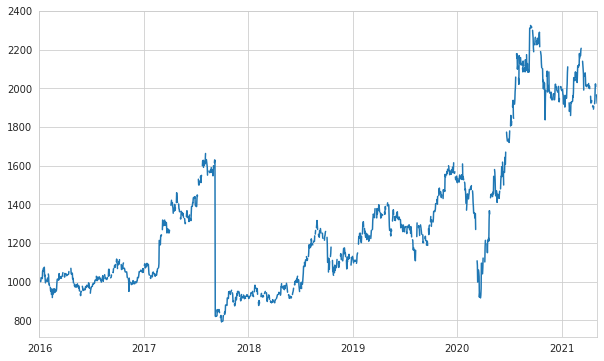

In [10]:
data.plot();

Очевидно, що більшість пропущених днів це вихідні (суббота та неділя), в які біржа не працює. Тому ці дні виключимо з даних, а інші заповнимо лінійною інтерполяцією.


In [11]:
data = data[data.index.dayofweek < 5]
data = data.interpolate(method='linear')
data.describe()

count    1395.000000
mean     1312.170278
std       377.331252
min       791.750000
25%      1014.925000
50%      1230.150000
75%      1477.500000
max      2325.000000
Name: Open Price, dtype: float64

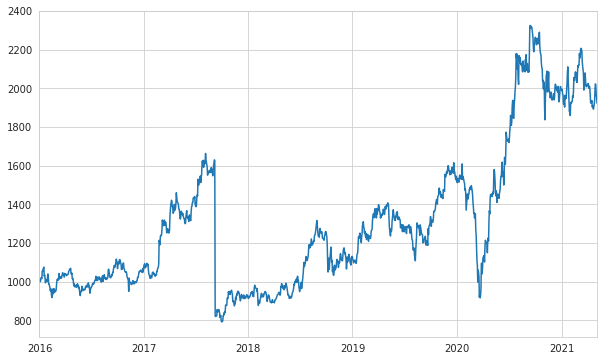

In [12]:
data.plot();

In [13]:
data.to_csv(GDRIVE+'/data_cleaned.csv')

# EDA

In [14]:
data = pd.read_csv(GDRIVE+'/data_cleaned.csv', index_col=0, parse_dates=True, squeeze=True)

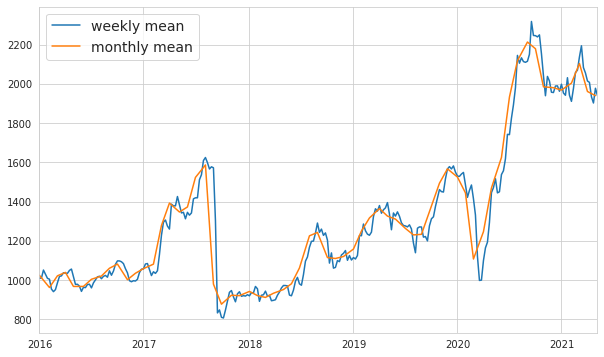

In [15]:
data.resample('w').mean().plot(label='weekly mean')
data.resample('M').mean().plot(label='monthly mean')
plt.legend();

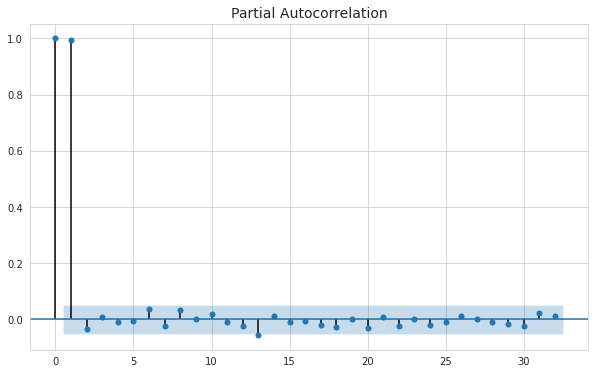

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(data, ax=plt.gca());

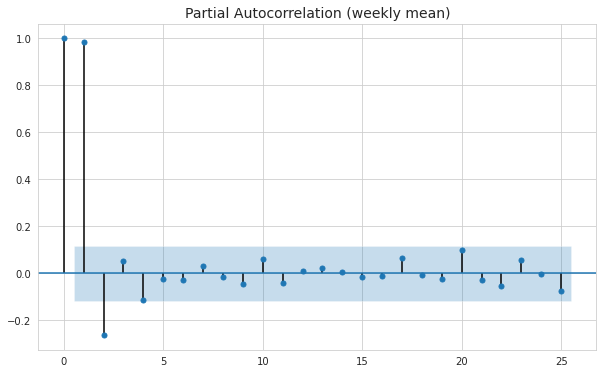

In [17]:
plot_pacf(data.resample('w').mean(), ax=plt.gca(), title="Partial Autocorrelation (weekly mean)");

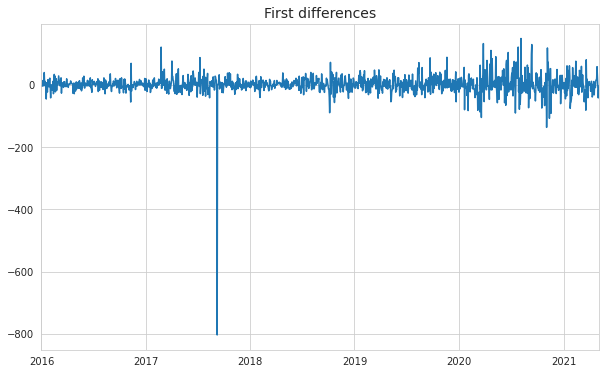

In [18]:
data.diff().plot(title="First differences");

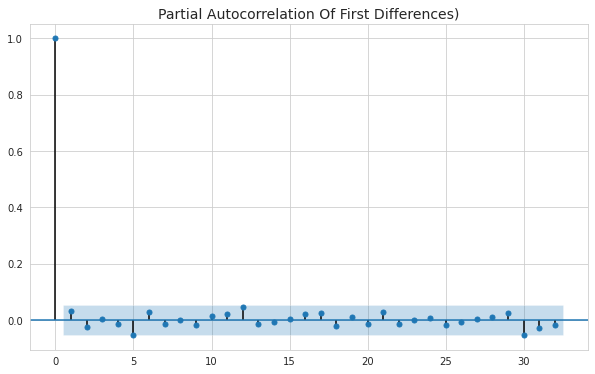

In [19]:
plot_pacf(data.diff()[1:], ax=plt.gca(), title="Partial Autocorrelation Of First Differences");

З візуального аналізу можна зробити висновок, що ряд має тренд першого порядку та нестаціонарну дисперсію, а також можна стверджувати про наявність  певного порядку автокорелляції.

# Models

In [20]:
data = pd.read_csv(GDRIVE+'/data_cleaned.csv', index_col=0, parse_dates=True, squeeze=True)
idx = len(data)//4
scaler = layers.experimental.preprocessing.Normalization()
scaler.adapt(data.values)
data_scaled = scaler(data)

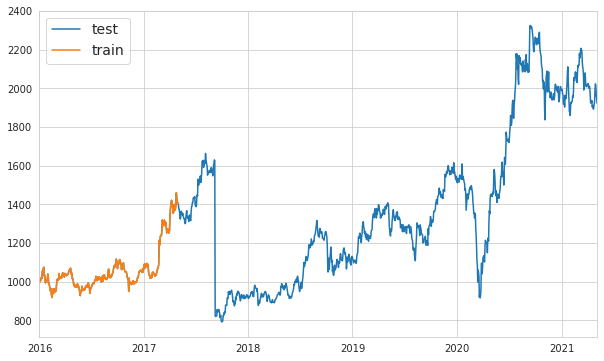

In [21]:
data.plot(label='test')
data[:idx].plot(label='train')
plt.legend();

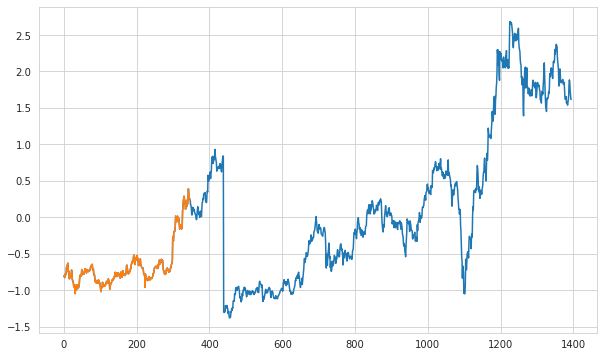

In [22]:
plt.plot(data_scaled)
plt.plot(data_scaled[:idx]);

#### Helping functions

In [23]:
compile_params = {
    'loss': 'mse',
    'optimizer': keras.optimizers.Adam(clipnorm=1.),
    'metrics': [
        MeanAbsolutePercentageError(name='mape'),
        MeanAbsoluteError(name='mae')
    ]
}

In [24]:
def window_split(data, x_len, y_len=1, offset=0):
    '''
    Prepares data in array format for supervised learning
    in similar way as keras.preprocessing.timeseries_dataset_from_array
    but returns a numpy arrays instead
    '''
    if isinstance(data, pd.Series):
        data = data.values
    n = len(data) - x_len - y_len - offset + 1
    X = [data[i:i+x_len] for i in range(n)]
    Y = [data[i:i+y_len] for i in range(x_len+offset, n+x_len+offset)]
    X = np.array(X).reshape(-1, x_len, 1)
    Y = np.array(Y).reshape(-1, y_len)
    return X, Y

# def window_seq_split(data, x_len, y_len=1):
#     if isinstance(data, pd.Series):
#         data = data.values
#     n = len(data) - x_len - y_len + 1
#     X = [data[i:i+x_len] for i in range(n)]
#     Y = [[data[i+j:i+x_len+j] for i in range(n)] for j in range(1, y_len+1)]
#     X = np.array(X).reshape(-1, x_len, 1)
#     Y = np.array(Y).reshape(-1, x_len, y_len)
#     return X, Y

def create_data(window=50, y_len=1, offset=0, seq=False):
    '''
    Creates a dictionary of training and validation data
    from data_scaled using window_split()
    '''
    if not seq:
        X_train, y_train = window_split(data_scaled[:idx], window, y_len, offset=offset)
        X_val, y_val = window_split(data_scaled[idx-window: ], window, y_len, offset=offset)
    else:
        X_train, y_train = window_seq_split(data_scaled[:idx], window, y_len)
        X_val, y_val = window_seq_split(data_scaled[idx-window: ], window, y_len)
    return {
        'x': X_train,
        'y': y_train,
        'validation_data': (X_val, y_val)
    }

from tqdm.notebook import tqdm, trange

def longterm_predict(model, data, predict_len):
    '''
    Forecasts predict_len steps with model, passing data as input
    '''
    data = data.reshape(1, -1, 1)[:, -50:, :]
    pred_list = []
    for i in trange(predict_len):
        pred = model.predict(data).ravel()[0].reshape(1,1,1)
        pred_list.append(pred)
        data = np.hstack([data, pred])[:, -50:, :]
    return np.vstack(pred_list).ravel()

def make_stateful(layer):
    res = layer.__class__.from_config(layer.get_config())
    if isinstance(res, layers.RNN):
        res.stateful = True
    return res

def longterm_predict_stateful(model, data, predict_len):
    '''
    Forecasts predict_len steps with model, passing data as input
    '''
    model_copy = keras.models.clone_model(model, clone_function=make_stateful, input_tensors=[Input(batch_size=1, shape=(None, 1))])
    print(model_copy.summary())
    model_copy.set_weights(model.get_weights()) 
    data = data.reshape(1, -1, 1)
    pred = model_copy.predict(data).ravel()[0].reshape(1,1,1)
    pred_list = []
    for i in trange(predict_len):
        pred = model_copy.predict(pred).ravel()[0].reshape(1,1,1)
        pred_list.append(pred)
    return np.vstack(pred_list).ravel()

def plot_results(model, history, data_dict, seq=False, longterm=False):
    '''
    Plots learning curves and series of predictions
    '''
    history = history.history
    X_train, y_train = data_dict['x'], data_dict['y']
    (X_val, y_val) = data_dict['validation_data']

    fig = plt.figure(constrained_layout=True, figsize=(13, 9))
    gs = GridSpec(3, 3, figure=fig)

    ax = fig.add_subplot(gs[0, 0])
    ax.plot(history['loss'], label=f"train: {history['loss'][-1]:.4f}")
    ax.plot(history['val_loss'], label=f"val: {history['val_loss'][-1]:.4f}")
    ax.set_title('MSE')
    ax.legend()

    ax = fig.add_subplot(gs[0, 1])
    ax.plot(history['mape'], label=f"train: {history['mape'][-1]:.4f}");
    ax.plot(history['val_mape'], label=f"val: {history['val_mape'][-1]:.4f}")
    ax.set_title('MAPE')
    ax.legend()

    ax = fig.add_subplot(gs[0, 2])
    ax.plot(history['mae'], label=f"train: {history['mae'][-1]:.4f}");
    ax.plot(history['val_mae'], label=f"val: {history['val_mae'][-1]:.4f}")
    ax.set_title('MAE')
    ax.legend()

    ax = fig.add_subplot(gs[1:, :])
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    if seq:
      train_pred = train_pred[:, 0]
      val_pred = val_pred[:, 0]
      y_train = y_train[:, 0]
      y_val = y_val[:, 0]
    
    ax.plot(np.vstack([y_train, y_val]), label="Real values")
    ax.plot(np.vstack([train_pred, val_pred]), label="Val predict")
    ax.plot(train_pred, label="Train predict")
    if longterm=='stateful':
      lt_pred = longterm_predict_stateful(model, data_scaled[:idx].numpy(), len(y_val))
      ax.plot(range(len(y_train), len(y_train)+len(lt_pred)), lt_pred, '--', label="Long-term predict")
    elif longterm==True:
      lt_pred = longterm_predict(model, data_scaled[:idx].numpy(), len(y_val))
      ax.plot(range(len(y_train), len(y_train)+len(lt_pred)), lt_pred, '--', label="Long-term predict")
    ax.legend();

def validate_model(model, timestamps=50, epochs=20, batch_size=64, longterm=False):
    '''
    Compiles and fits the model, then plots results using plot_results()
    '''
    model.compile(**compile_params)
    data_dict = create_data(timestamps)
    history = model.fit(**data_dict, epochs=epochs, batch_size=batch_size, verbose=1)
    clear_output()
    plot_results(model, history, data_dict, longterm=longterm)

In [25]:
d = create_data(50)
d['x'].shape, d['y'].shape

((298, 50, 1), (298, 1))

## One-layer models

### Simple RNN

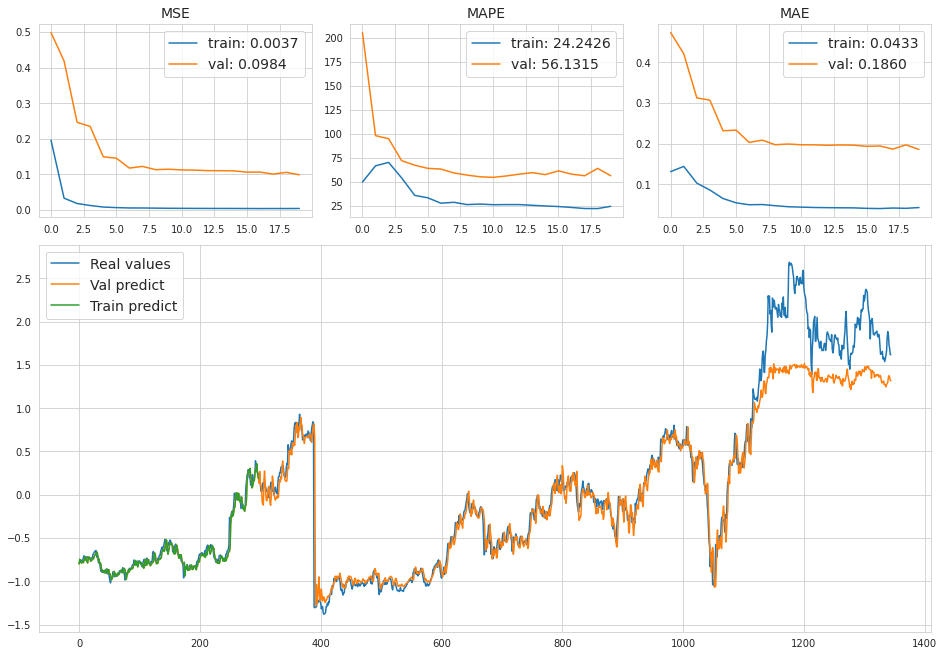

In [26]:
model = Sequential(
  [
    Input((None, 1)),
    SimpleRNN(32),
    Dense(1)
  ],
)
validate_model(model, timestamps=50, epochs=20, batch_size=64)

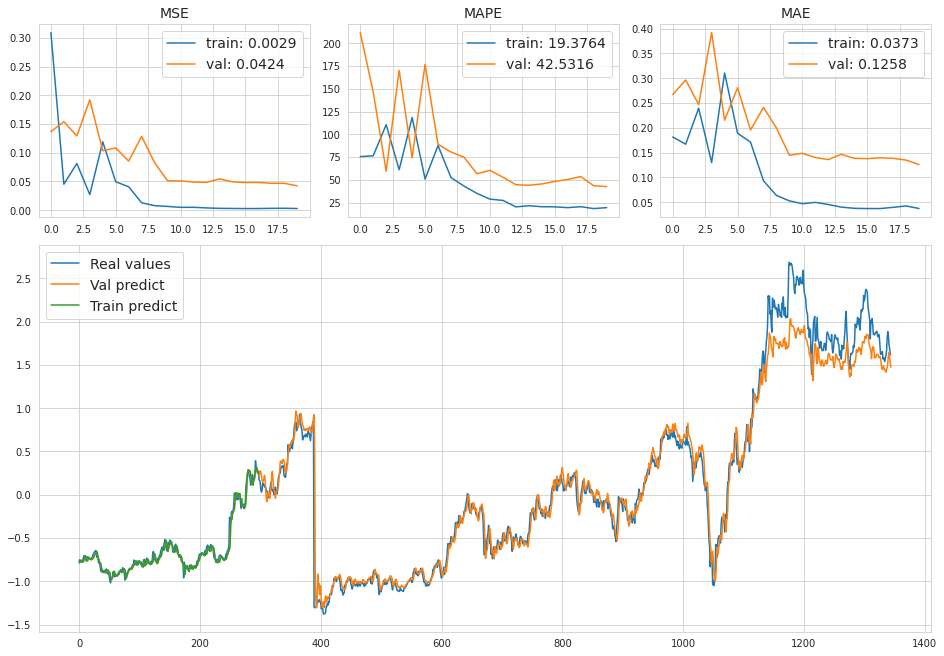

In [27]:
model = Sequential(
  [
    Input((None, 1)),
    SimpleRNN(128),
    Dense(1)
  ],
)
validate_model(model, timestamps=50, epochs=20, batch_size=64)

### LSTM

#### 32 cells

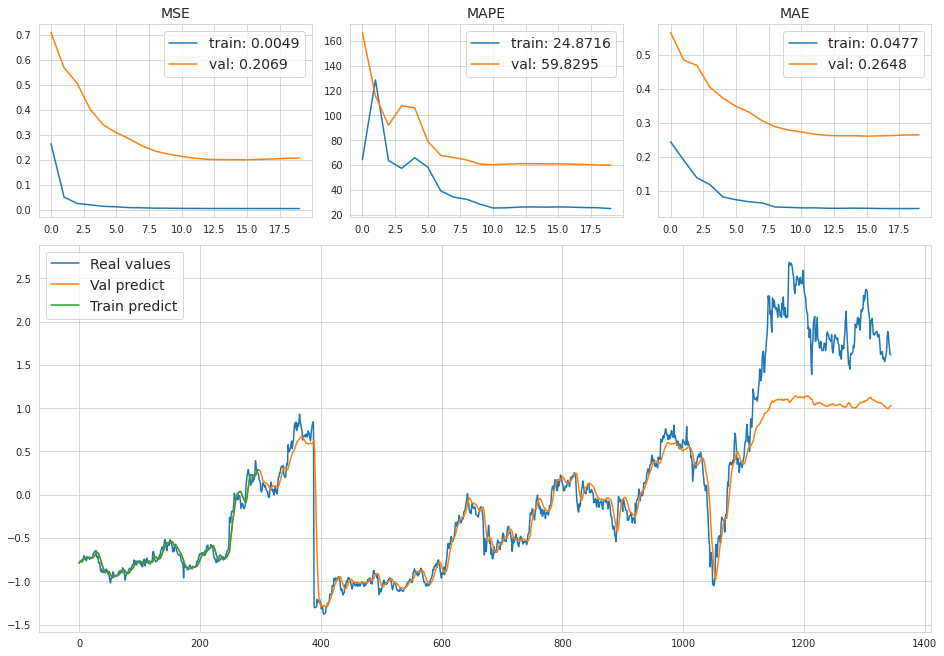

In [28]:
model = Sequential(
  [
    Input((None, 1)),
    LSTM(32),
    Dense(1)
  ]
)
validate_model(model, timestamps=50, epochs=20, batch_size=64)

#### 128 cells

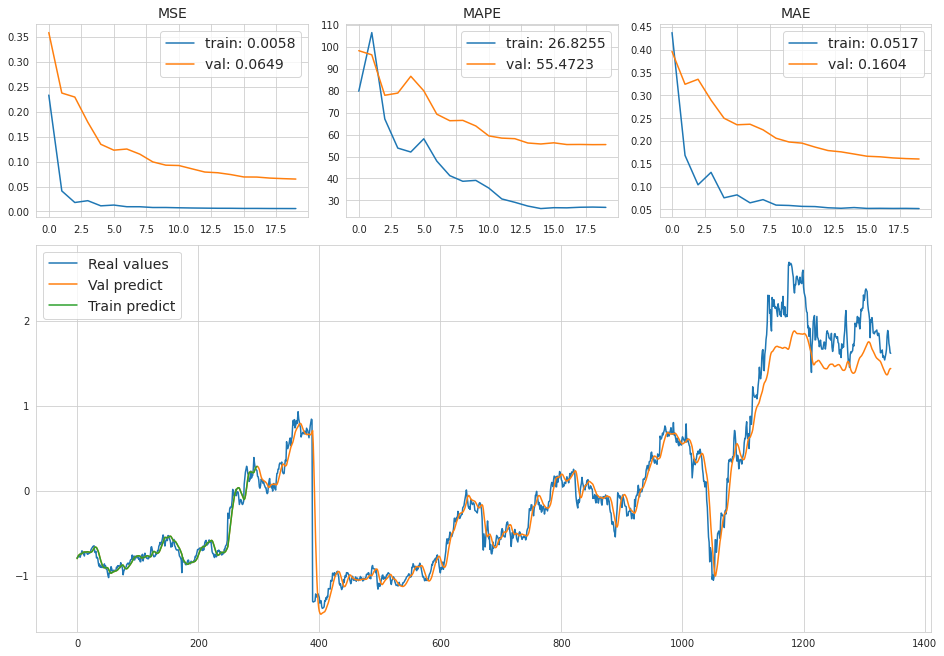

In [29]:
model = Sequential(
  [
    Input((None, 1)),
    LSTM(128),
    Dense(1)
  ]
)
validate_model(model, timestamps=50, epochs=20, batch_size=64)

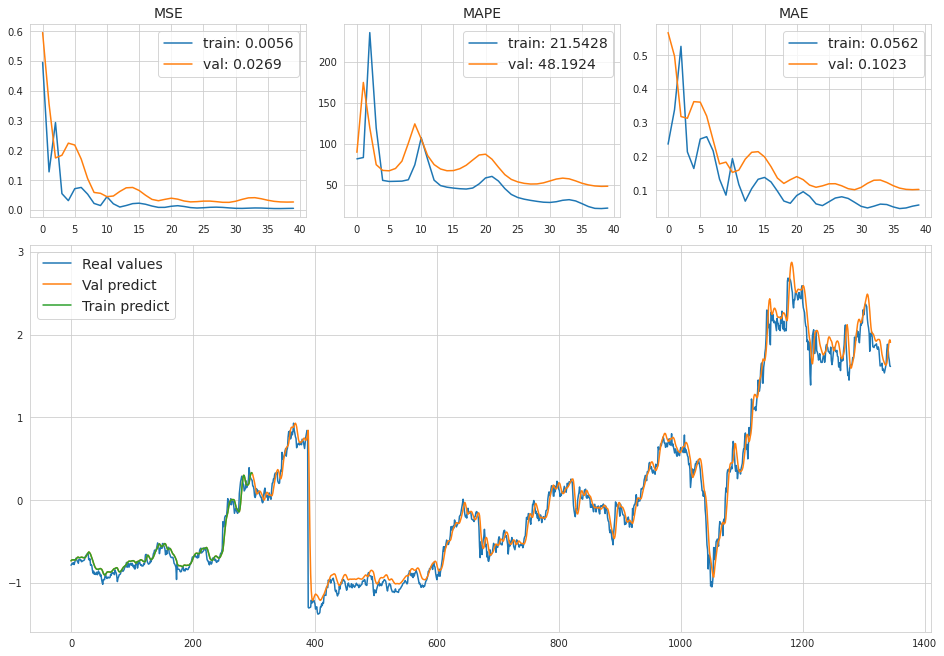

In [30]:
model = Sequential(
  [
    Input((None, 1)),
    LSTM(128),
    Dense(1)
  ]
)
validate_model(model, timestamps=50, epochs=40, batch_size=300)

### GRU

#### 32 cells

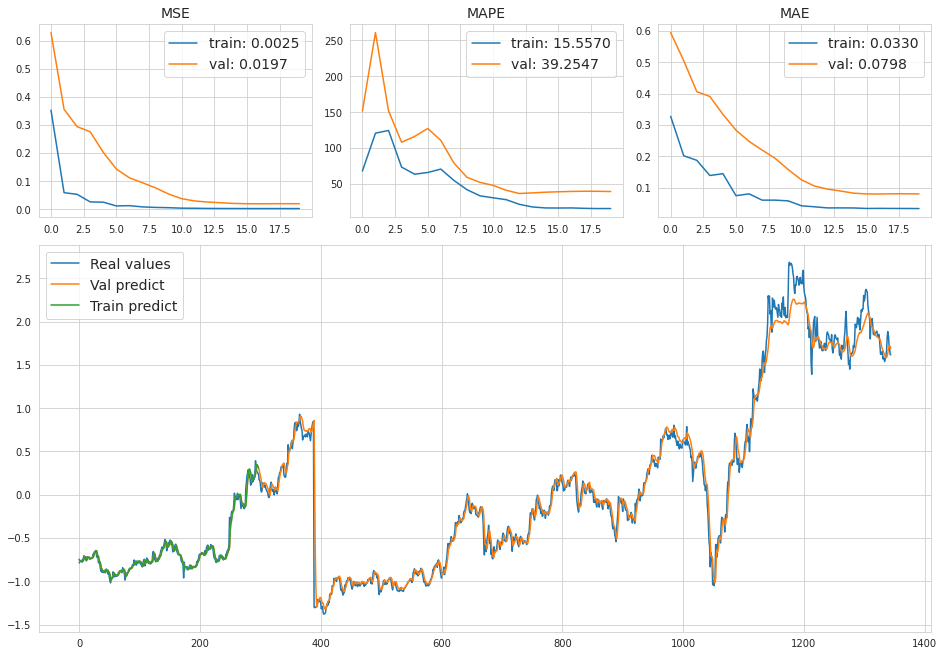

In [31]:
model = Sequential(
  [
    Input((None, 1)),
    GRU(32),
    Dense(1)
  ]
)
validate_model(model, timestamps=50, epochs=20, batch_size=64)

#### 128 cells

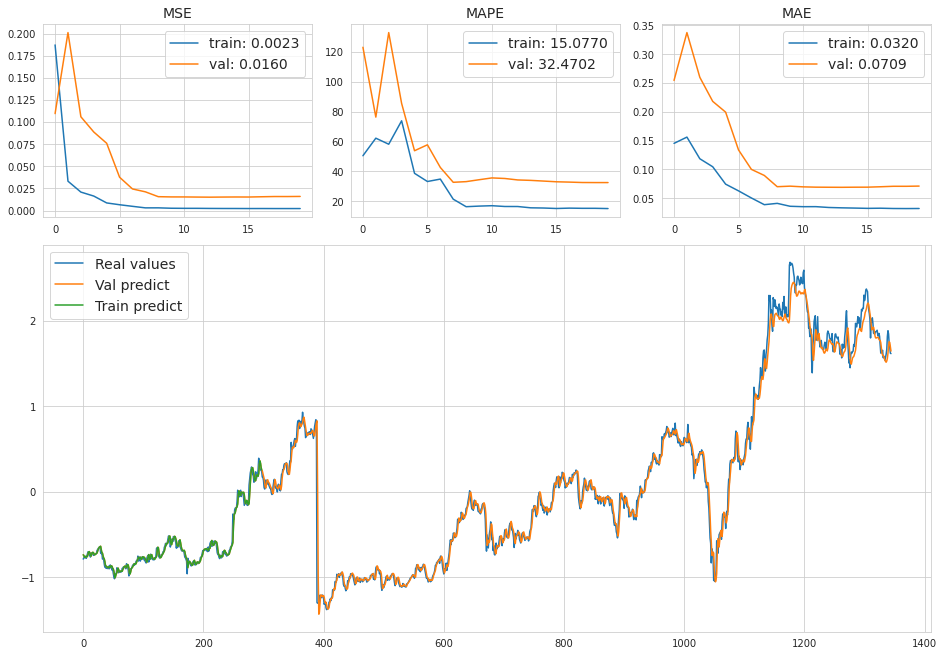

In [32]:
model = Sequential(
  [
    Input((None, 1)),
    GRU(128),
    Dense(1)
  ]
)
validate_model(model, timestamps=50, epochs=20, batch_size=64)

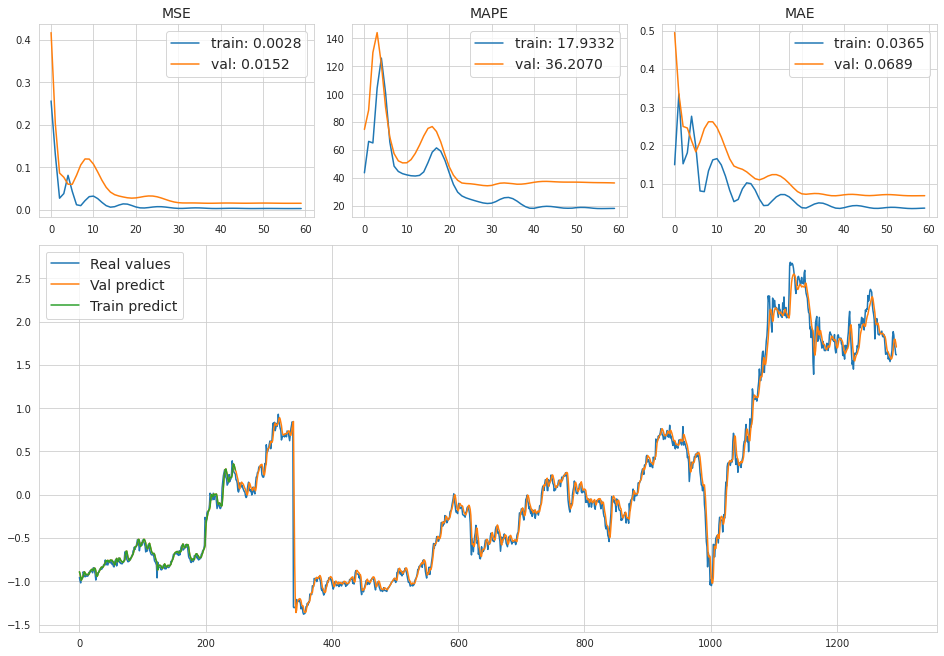

In [33]:
model = Sequential(
  [
    Input((None, 1)),
    GRU(128),
    Dense(1)
  ]
)
validate_model(model, timestamps=100, epochs=60, batch_size=300)

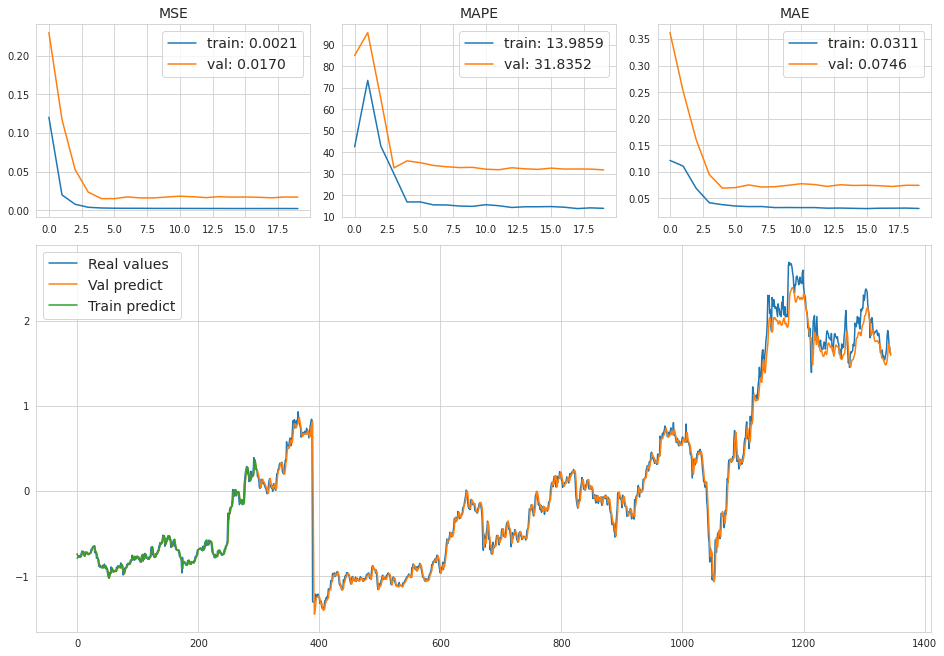

In [34]:
model = Sequential(
  [
    Input((None, 1)),
    GRU(128),
    Dense(1)
  ]
)
validate_model(model, timestamps=50, epochs=20, batch_size=32,)

З цих графіків можна зробити наступні висновки:
- базові реккурентні шари мають схильність до систематичнох похибки, що, певно, пов'язано з запом'ятовуванням паттернів навчальної вибірки.  
- LSTM сильно "зглажує" прогнозовані значення відносно реальних, що скоріш за все пов'язано з впливом довгострокової пам'яті, а також демонструє погану здатність до екстраполяції, особливо при малій кількості нейронів.
- GRU є оптимальним варіантом в данному випадку, оскільки показує гарні показники та якісну екстраполяцію майже при різних розмірах батчу та кількості нейронів

## Multilayer models

### GRU

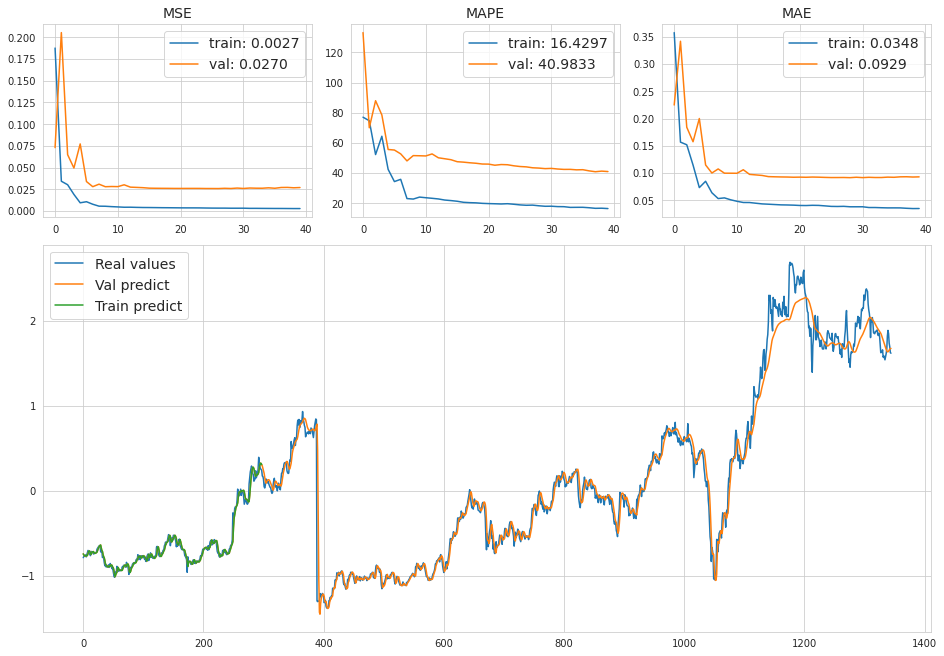

In [35]:
model = Sequential(
  [
    Input((None, 1)),
    GRU(128, return_sequences=True),
    GRU(128, return_sequences=True),
    GRU(128),
    Dense(1)
  ]
)
validate_model(model, timestamps=50, epochs=40, batch_size=64)

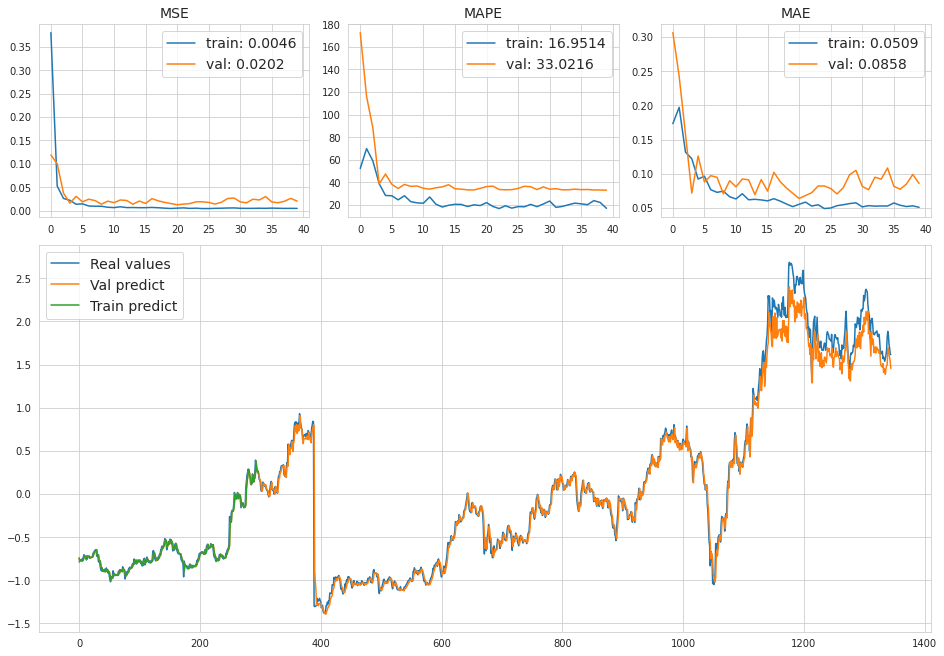

In [36]:
model = Sequential(
  [
    Input((None, 1)),
    GRU(256, return_sequences=True),
    Dropout(0.3),
    GRU(256, return_sequences=True),
    Dropout(0.3),
    GRU(128),
    Dropout(0.3),
    Dense(1)
  ]
)
validate_model(model, timestamps=50, epochs=40, batch_size=64)

### LSTM

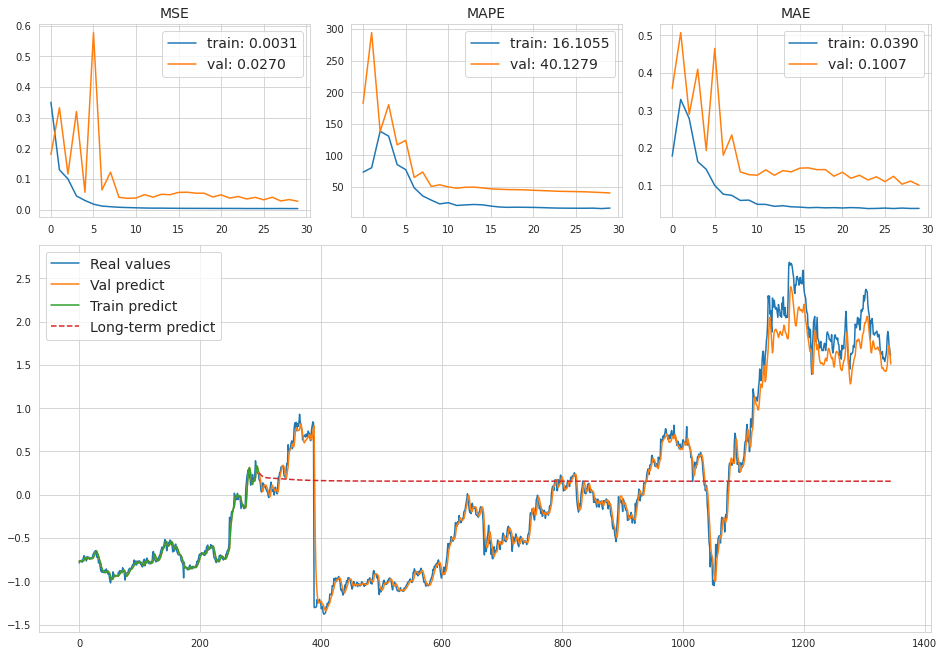

In [37]:
model = Sequential(
  [
    Input((None, 1)),
    LSTM(256, return_sequences=True),
    # LSTM(256, return_sequences=True),
    LSTM(256),
    Dense(1)
  ]
)
validate_model(model, timestamps=50, epochs=30, batch_size=64, longterm=True)

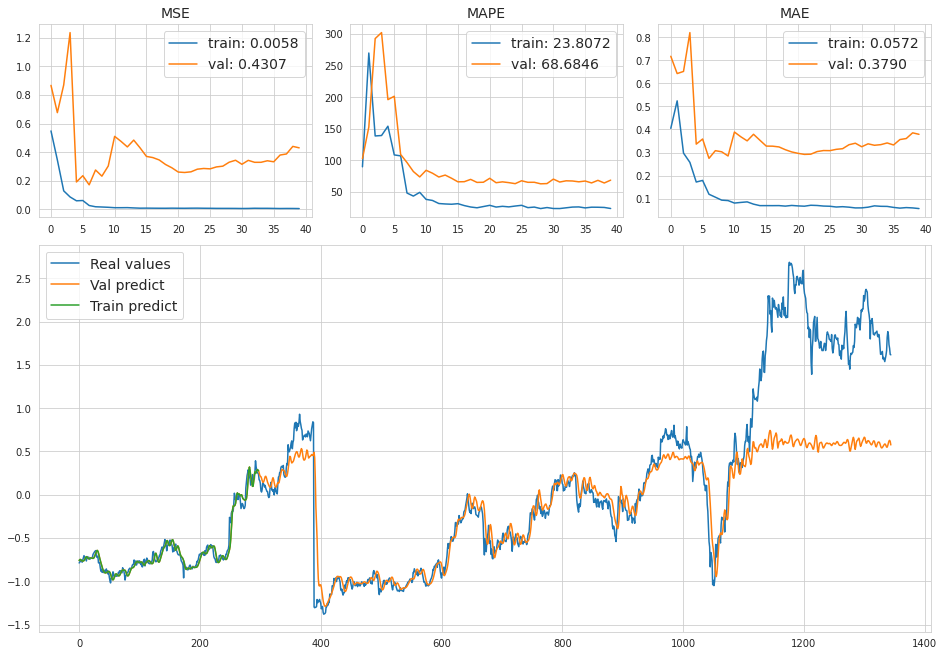

In [38]:
model = Sequential(
  [
    Input((None, 1)),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    LSTM(256),
    Dropout(0.3),
    Dense(1)
  ]
)
validate_model(model, timestamps=50, epochs=40, batch_size=64)

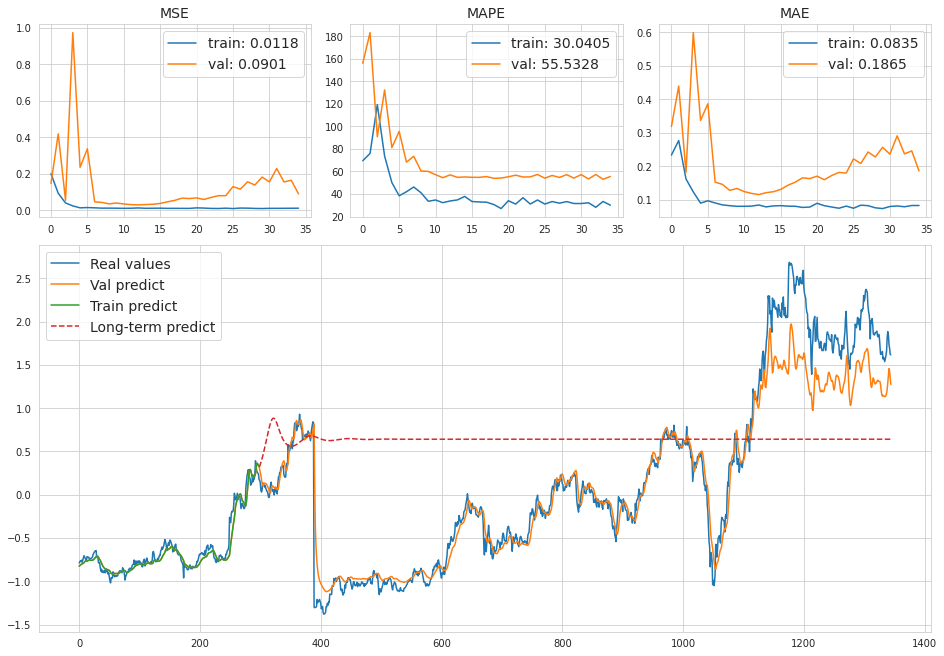

In [39]:
model = Sequential(
  [
    Input((None, 1)),
    LSTM(256, return_sequences=True, recurrent_dropout=0.1, dropout=0.1),
    # LSTM(256, return_sequences=True),
    Dropout(0.1),
    LSTM(128, recurrent_dropout=0.1, dropout=0.1),
    Dropout(0.1),
    Dense(1)
  ]
)
validate_model(model, timestamps=50, epochs=35, batch_size=64, longterm=True)

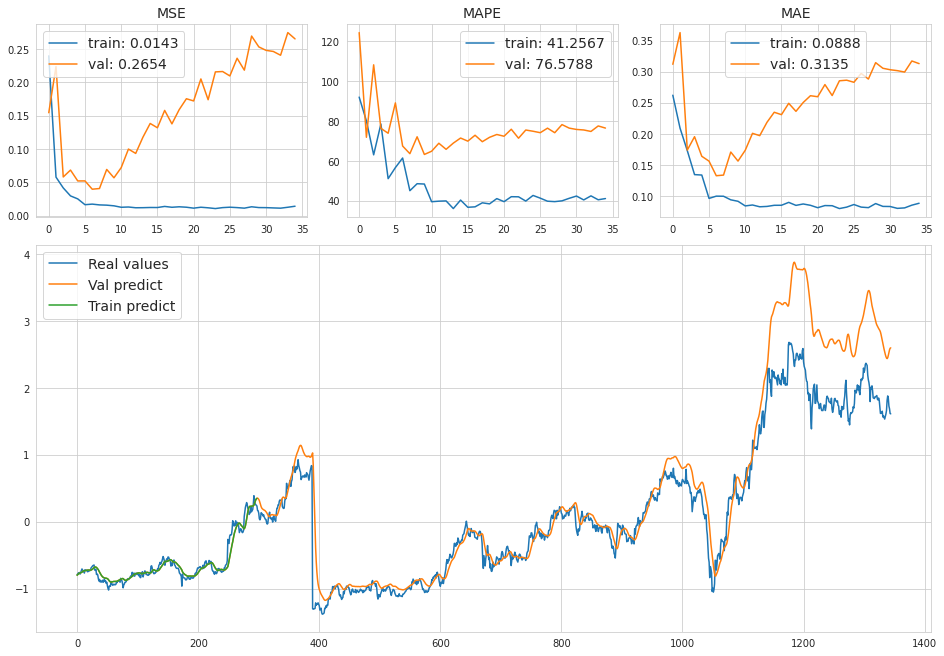

In [40]:
model = Sequential(
  [
    Input((None, 1)),
    LSTM(256, return_sequences=True, recurrent_dropout=0.1, dropout=0.1),
    # LSTM(256, return_sequences=True),
    Dropout(0.1),
    LSTM(128, recurrent_dropout=0.1, dropout=0.1),
    Dropout(0.1),
    Dense(1)
  ]
)
validate_model(model, timestamps=50, epochs=35, batch_size=64, longterm=False)

## Conv1D

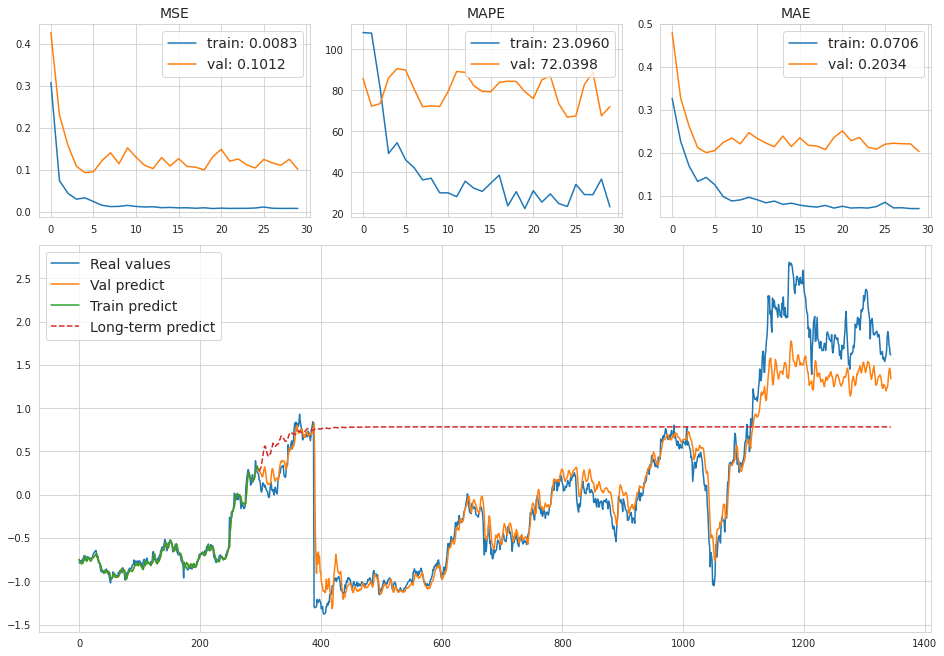

In [41]:
model = Sequential(
  [
    Input((50, 1)),
    Conv1D(32, 5, 1, padding='same', activation='tanh'),
    Conv1D(32, 5, 1, padding='same', activation='tanh'),
    MaxPool1D(2),
    Dropout(0.4),
    Conv1D(32, 5, 1, padding='same', activation='tanh'),
    Conv1D(32, 5, 1, padding='same', activation='tanh'),
    MaxPool1D(2),
    Dropout(0.3),
    Flatten(),
    Dense(1)
  ]
)

model.summary()
validate_model(model, timestamps=50, epochs=30, batch_size=64, longterm=False)

Принаймні, згорткові шари "намагаються" побудувати багатокроковий прогноз, перш ніж збігаються до константи.

## RNN + Conv1d

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_61 (GRU)                 (1, None, 128)            50304     
_________________________________________________________________
time_distributed_118 (TimeDi (1, None, 128, 1)         0         
_________________________________________________________________
time_distributed_119 (TimeDi (1, None, 62, 16)         96        
_________________________________________________________________
time_distributed_120 (TimeDi (1, None, 992)            0         
_________________________________________________________________
dropout_69 (Dropout)         (1, None, 992)            0         
_________________________________________________________________
gru_62 (GRU)                 (1, None, 128)            430848    
_________________________________________________________________
time_distributed_121 (TimeDi (1, None, 128, 1)       

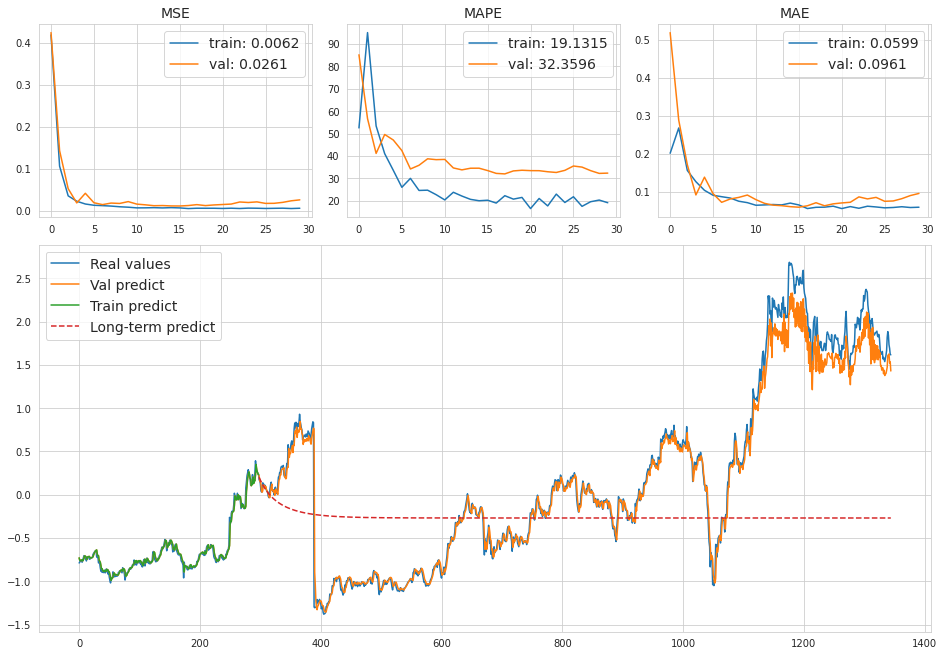

In [42]:
model = Sequential(
  [
    Input((None, 1)),
    GRU(128, return_sequences=True),
    TimeDistributed(Reshape((128, 1))),
    TimeDistributed(Conv1D(16, 5, 2)),
    TimeDistributed(Reshape((2*31*16,))),
    Dropout(0.4),
    GRU(128, return_sequences=True),
    TimeDistributed(Reshape((128, 1))),
    TimeDistributed(Conv1D(16, 5, 2)),
    TimeDistributed(Reshape((2*31*16,))),
    Dropout(0.4),
    GRU(128),
    layers.Flatten(),
    Dropout(0.4),
    Dense(1)
  ]
)

model.summary()
validate_model(model, timestamps=50, epochs=30, batch_size=64, longterm=True)

# Summary

Всі розглянуті моделі мають спільний недолік: вони здатні прогнозувати лише на крок вперед. В даних умовах, зміна реального фінансового ряду не визначається лише авторегрессійною складовою, а здебільшого зовнішніми чинниками, інформацію про які  ми не маємо. Були здійснені, але не включені до кінцевих результатів, спроби навчити модель як seq-to-seq замість seq-to-one підходу, як у всіх розглянутих вище моделей - суттєвої зміни результатів не відбулось, або збільшити кількість вихідних нейронів (seq-to-vec) де кожен прогнозує значення в t+1, t+2, ... t+k момент часу - така модель сильно зглажує прогозовані значення, а на довгостроковому прогнозі видає періодичний графік. В данному випадку можливо сможе допомогти зміна функції втрат на який зважений, відносно віддаленості в часі, варіант. А також була спроба прогнозувати ряд повернень, на чому значущих результатів досягти не вдалось, що ще раз підтверджує гіпотезу про те, що моделі такої конфігурації не можуть передбачити коливання через недолік інформації, а лише моделюють тренд.

Тому слід перейти до більш корректної задачі в залежності від потреб:
 - якщо ціль полягає в прогнозуванні однієї точки наперед, тоді слід розглядати не такий довгий проміжок валідаційних данних, та порівнювати підходи вже на ньому.
 - якщо ціль полягає в моделюванні тренда наперед на багато точок, тоді слід змешити вплив коливаннь, згладивши ряд, наприклад взявши середні за тижнем або за місяцем значення.

В данному випадку: коли ми перевіряємо здатність узагальнення одноточкового прогнозу на великому періоді данних, то найкращою моделлю слід прийняти мережу з одним шаром GRU-комірок, що показала найкращий результат за усіма метриками на валідації, та прицьому має доволі мало параметрів.